In [1]:
import pandas as pd
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
import gc
from tqdm import tqdm
import time
from collections import defaultdict
import copy
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from transformers import AutoModel, AutoTokenizer
from transformers import BatchEncoding

import pdb

import wandb

# Defining global parameters

In [2]:
def get_available_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"
    
CONFIG = {
    "seed": 42,
    "epochs": 12, # 42, ~MAX 20 hours of training
    "train_batch_size": 16,
    "valid_batch_size": 64,
    "learning_rate": 5e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 5e-7,
    "T_max": 12,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": get_available_device(),
    'labels': ['unable_to_assess', 'not_close_match','close_match', 'near_exact_match', 'exact_match'], # 'unable_to_assess', 'not_close_match','close_match', 'near_exact_match', 'exact_match'
    'FP': 'molformer', # 'fp', 'molformer', 'ECFP', 'grover'
}

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(seed=CONFIG['seed'])

# Read the data that has duplicates REMOVED
## Validation set of 20% of the size

In [3]:
train_df = pd.read_pickle('../data/train_split_remove_duplicates_all_embeddings.pkl')
valid_df = pd.read_pickle('../data/valid_split_remove_duplicates_all_embeddings.pkl')

In [4]:
if CONFIG['FP'] == 'ECFP':
    CONFIG['input_size'] = 2048
elif CONFIG['FP'] == 'molformer':
    CONFIG['input_size'] = 768
elif CONFIG['FP'] == 'fp':
    CONFIG['input_size'] = 2215
elif CONFIG['FP'] == 'grover':
    CONFIG['input_size'] = 5000


## Wrapping in Pytorch Dataset

In [18]:
class EnvedaDatasetSmileMolformer(Dataset):
    def __init__(self, dataframe, labels = ['unable_to_assess', 'close_match', 'not_close_match', 
                                            'near_exact_match', 'exact_match']):
        """
        Args:
            dataframe (pd.DataFrame): A DataFrame containing 'ground_truth_embeddings', 
                                       'predicted_embeddings', and output columns.
        """
        self.dataframe = dataframe
        
        # Convert embeddings to tensors
        self.ground_truth_embeddings = torch.tensor(dataframe['ground_truth_embeddings'].tolist(), dtype=torch.float32)
        self.predicted_embeddings = torch.tensor(dataframe['predicted_embeddings'].tolist(), dtype=torch.float32)
        
        # Get molecular smiles
        self.ground_truth_smiles = dataframe['ground_truth_smiles'].to_list()
        self.predicted_smiles = dataframe['predicted_smiles'].to_list()

        # Convert labels to tensor
        self.labels = torch.tensor(dataframe[labels].values, dtype=torch.float32)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Generates one sample of data."""
        #return self.ground_truth_embeddings[idx].squeeze(0), self.predicted_embeddings[idx].squeeze(0), self.labels[idx]
        return self.ground_truth_smiles[idx], self.predicted_smiles[idx], self.labels[idx]

In [19]:
trainset = EnvedaDatasetSmileMolformer(dataframe=train_df, labels=CONFIG['labels'])
validset = EnvedaDatasetSmileMolformer(dataframe=valid_df, labels=CONFIG['labels'])

## Wrapping in Pytorch DataLoader

In [20]:
trainloader, validloader = DataLoader(trainset, batch_size=CONFIG['train_batch_size']), \
                           DataLoader(validset, batch_size=CONFIG['valid_batch_size'])

In [22]:
gt, pred, labels = next(iter(trainloader))
print(len(gt), len(pred), labels.shape)


16 16 torch.Size([16, 5])


# Defining neural network

In [13]:
molformer_embedder = AutoModel.from_pretrained("ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True).to(CONFIG['device'])
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)


In [158]:
# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self, feature_embedder=molformer_embedder, input_dim=768, output_dim=4):
        super(SiameseNetwork, self).__init__()
        self.smiler_embedder = feature_embedder
        self.smiler_embedder.eval() 
        # Freeze feature embedder
        # for param in self.smiler_embedder.parameters():
        #     param.requires_grad = False
        
        self.fc = nn.Sequential(
        nn.Linear(input_dim, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2))

        self.fc5 = nn.Linear(128, output_dim)

        
    def forward_one(self, x):
        return self.fc(x)

    def forward(self, input1, input2):
        # Check if input1 is a dictionary or tensor
        if isinstance(input1, BatchEncoding) or isinstance(input1, dict):
            # pdb.set_trace()
            input1 = self.smiler_embedder(**input1, output_hidden_states=True).pooler_output
        elif isinstance(input1, torch.Tensor):
            # pdb.set_trace()
            input1 = self.smiler_embedder(input1, output_hidden_states=True).pooler_output  # Adjust as needed for tensor input

        # Check if input2 is a dictionary or tensor
        if isinstance(input2, BatchEncoding) or isinstance(input2, dict):
            input2 = self.smiler_embedder(**input2, output_hidden_states=True).pooler_output
        elif isinstance(input2, torch.Tensor):
            input2 = self.smiler_embedder(input2, output_hidden_states=True).pooler_output  # Adjust as needed for tensor input
        # pdb.set_trace()
        out1 = self.forward_one(input1)
        out2 = self.forward_one(input2)
        # pdb.set_trace()
        # Combine both outputs by subtraction
        combined = torch.sub(out1, out2)  # maybe torch.abs(out1 - out2)
        output = self.fc5(combined)                  # Outputs raw logits
        return output



In [159]:
# model = SiameseNetwork(output_dim=5, feature_embedder=molformer_embedder)
# model.to(CONFIG['device'])
    
# model((tokenizer(gt, return_tensors='pt', padding=True, truncation=True)).to(CONFIG['device']), 
#       (tokenizer(pred, return_tensors='pt', padding=True, truncation=True)).to(CONFIG['device']))
# # model(gt, pred)

# Validation 

In [160]:

@torch.no_grad()
def valid_one_epoch(model, dataloader, criterion, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    running_f1 = 0.0 
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        
        gt, preds, targets = data
        gt, preds = tokenizer(gt, return_tensors='pt', padding=True, truncation=True), \
                    tokenizer(preds, return_tensors='pt', padding=True, truncation=True)
        # pdb.set_trace()
        gt, preds, targets = gt.to(CONFIG['device']), preds.to(CONFIG['device']), targets.to(CONFIG['device'])
        batch_size = targets.shape[0]
        
        with autocast():
            outputs = model(gt, preds)
            loss = criterion(outputs, targets)
            loss = loss / CONFIG['n_accumulate']
        
        probabilities = torch.softmax(outputs, dim=1).detach().cpu().numpy() if outputs.shape[1] > 1 else torch.sigmoid(outputs).detach().cpu().numpy()
        preds = np.eye(outputs.shape[1])[np.argmax(probabilities, axis=1)] if outputs.shape[1] > 1 else (probabilities > 0.5).astype(float)
        
        auroc = average_precision_score(targets.cpu().numpy(), probabilities)
        f1 = f1_score(targets.cpu().numpy(), preds, average='weighted')
        
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        running_f1 += (f1 * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        epoch_f1 = running_f1 / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc, 
                        Valid_F1=epoch_f1,
                        )   
    gc.collect()
    
    return epoch_loss, epoch_auroc, epoch_f1

## Loading pretrained model

In [161]:
model = SiameseNetwork(input_dim=CONFIG['input_size'], output_dim=len(CONFIG['labels'])).to(CONFIG['device'])
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])

class_distribution = {'unable_to_assess': 10,
                      'not_close_match': 109, 
                      'close_match': 125, 
                      'near_exact_match': 66, 
                      'exact_match': 12,
                      'good_enough_for_prioritization': 224}

# Calculate class weights
total_samples = sum(class_distribution.values())
class_weights = {label: total_samples / (len(class_distribution) * count) for label, count in class_distribution.items()}

# Convert weights to a tensor
weights = torch.tensor([class_weights['unable_to_assess'],
                        class_weights['not_close_match'],
                        class_weights['close_match'],
                        class_weights['near_exact_match'],
                        class_weights['exact_match']], dtype=torch.float32).to(CONFIG['device'])

# find the indeces of keys in class_distribution in CONFIG['labels']
weights = torch.tensor([class_weights[c] for c in CONFIG['labels']], dtype=torch.float32).to(CONFIG['device'])

# Modify the loss function in your training loop
criterion = nn.CrossEntropyLoss(weight=weights)



# Load pretrained model

In [162]:
# set Strict to false because of the newly added MolFormer embedder
model.load_state_dict(torch.load('../results/best_F1_model_siamese_multiclass_sub_molformer.bin', map_location=CONFIG['device']), strict=False) 

_IncompatibleKeys(missing_keys=['smiler_embedder.embeddings.word_embeddings.weight', 'smiler_embedder.encoder.layer.0.attention.self.query.weight', 'smiler_embedder.encoder.layer.0.attention.self.query.bias', 'smiler_embedder.encoder.layer.0.attention.self.key.weight', 'smiler_embedder.encoder.layer.0.attention.self.key.bias', 'smiler_embedder.encoder.layer.0.attention.self.value.weight', 'smiler_embedder.encoder.layer.0.attention.self.value.bias', 'smiler_embedder.encoder.layer.0.attention.self.feature_map.weight', 'smiler_embedder.encoder.layer.0.attention.output.dense.weight', 'smiler_embedder.encoder.layer.0.attention.output.dense.bias', 'smiler_embedder.encoder.layer.0.attention.output.LayerNorm.weight', 'smiler_embedder.encoder.layer.0.attention.output.LayerNorm.bias', 'smiler_embedder.encoder.layer.0.intermediate.dense.weight', 'smiler_embedder.encoder.layer.0.intermediate.dense.bias', 'smiler_embedder.encoder.layer.0.output.dense.weight', 'smiler_embedder.encoder.layer.0.output

In [148]:
val_epoch_loss_molformer, val_epoch_auroc_molformer, val_epoch_f1_molformer = valid_one_epoch(
    model=model,
    dataloader=validloader,
    criterion=criterion,
    epoch=1
)

 50%|█████     | 1/2 [00:00<00:00,  1.13it/s, Epoch=1, Valid_Auroc=0.512, Valid_F1=0.428, Valid_Loss=1.86]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:01<00:00,  1.73it/s, Epoch=1, Valid_Auroc=0.418, Valid_F1=0.403, Valid_Loss=2.96]


# Interpretability with Integrated Gradients

In [112]:
from captum.attr import IntegratedGradients

In [165]:

def prepare_input(smile1, smile2):
    # Tokenize SMILES strings
    input1 = tokenizer(smile1, return_tensors='pt', padding=True, truncation=True).to(CONFIG['device'])
    input2 = tokenizer(smile2, return_tensors='pt', padding=True, truncation=True).to(CONFIG['device'])
    
    # Combine into a dictionary
    return {
        "input_ids": input1["input_ids"],
        "attention_mask": input1["attention_mask"],
        "input_ids_2": input2["input_ids"],
        "attention_mask_2": input2["attention_mask"]
    }



# Function to interpret the model's prediction
def interpret_model(smile1, smile2):
    # Prepare inputs
    input_dict = prepare_input(smile1, smile2)

    gt_smile = {'input_ids': input_dict["input_ids"].long(), \
                         'attention_mask': input_dict["attention_mask"].float()}
    pred_smile = {'input_ids': input_dict["input_ids_2"].long(), \
                      'attention_mask': input_dict["attention_mask_2"].float()}
    # Set model to evaluation mode
    model.eval()

    # Create IntegratedGradients object
    ig = IntegratedGradients(model)

    # Forward pass to get output
    output = model(gt_smile, pred_smile)
    output = torch.softmax(output, dim=1)
    
    # Get the index of the predicted class (assuming binary classification)
    predicted_class = torch.tensor([0, 1, 0, 0, 0])

    # Calculate attributions for both inputs
    attributions1 = ig.attribute((gt_smile['input_ids'], pred_smile['input_ids']), target=predicted_class)
    pdb.set_trace()
    attributions2 = ig.attribute(pred_smile['input_ids'], target=predicted_class)

    return attributions1, attributions2

# Example usage
idx = 42
smile1 = valid_df['predicted_smiles'].iloc[idx]  # Example SMILE string 1
smile2 = valid_df['ground_truth_smiles'].iloc[idx]  # Example SMILE string 2

attributions1, attributions2 = interpret_model(smile1, smile2)

# Convert attributions to numpy for easier visualization if needed
attributions1_np = attributions1.detach().numpy()
attributions2_np = attributions2.detach().numpy()

print("Attributions for SMILE 1:", attributions1_np)
print("Attributions for SMILE 2:", attributions2_np)


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got MPSFloatType instead (while checking arguments for embedding)

In [202]:
def prepare_input(smile1, smile2):
    # Tokenize SMILES strings
    input1 = tokenizer(smile1, return_tensors='pt', padding=True, truncation=True).to(CONFIG['device'])
    input2 = tokenizer(smile2, return_tensors='pt', padding=True, truncation=True).to(CONFIG['device'])
    
    # Combine into a dictionary
    return {
        "input_ids": input1["input_ids"],
        "attention_mask": input1["attention_mask"],
        "input_ids_2": input2["input_ids"],
        "attention_mask_2": input2["attention_mask"]
    }

def integrated_gradients(model, smile1, smile2, baseline=None, steps=50):
    if baseline is None:
        # pdb.set_trace()
        baseline = { 
                    "input_ids": torch.zeros(len(tokenizer(smile1)["input_ids"])).to(CONFIG['device']),
                    "attention_mask": torch.zeros(len(tokenizer(smile1)["attention_mask"])).to(CONFIG['device']),
                    "input_ids_2": torch.zeros(len(tokenizer(smile2)["input_ids"])).to(CONFIG['device']),
                    "attention_mask_2": torch.zeros(len(tokenizer(smile2)["attention_mask"])).to(CONFIG['device']) 
                }

    # Prepare inputs as dictionaries
    input_dict = prepare_input(smile1, smile2)

    # Scale inputs between baseline and input
    scaled_inputs = [{k: baseline[k] + (float(i) / steps) * (input_dict[k] - baseline[k]) for k in baseline.keys()} for i in range(steps + 1)]
    # pdb.set_trace()
    # Collect gradients
    grads_gt = []
    grads_pred = []
    for scaled_input in scaled_inputs:
        # scaled_input_tensor = {k: v.requires_grad_() for k, v in scaled_input.items()}
        
        gt_smile = {'input_ids': scaled_input["input_ids"].long(), \
                         'attention_mask': scaled_input["attention_mask"].float().requires_grad_(True)}
        pred_smile = {'input_ids': scaled_input["input_ids_2"].long(), \
                      'attention_mask': scaled_input["attention_mask_2"].float().requires_grad_(True)}
        
        output = model(gt_smile, pred_smile)
        model.zero_grad()
        
        target_one_hot = torch.eye(output.shape[1])[torch.argmax(output)]
        # Use the one-hot encoded target for backpropagation
        # pdb.set_trace()
        output.backward(torch.tensor(target_one_hot.clone().detach().requires_grad_(True)).to(CONFIG['device']).float().unsqueeze(0))
        pdb.set_trace()
        grads_gt.append(gt_smile['attention_mask'].grad.detach().cpu().numpy())     # should be input ids, but they don't have gradients
        grads_pred.append(pred_smile['attention_mask'].grad.detach().cpu().numpy())
    # Average the gradients
    pdb.set_trace()
    avg_grads_gt = np.mean(grads_gt[:-1], axis=0)
    avg_grads_pred = np.mean(grads_pred[:-1], axis=0)

    # Compute integrated gradients
    integrated_grads_gt = (input_dict['attention_mask'] - baseline['attention_mask']).detach().cpu().numpy() * avg_grads_gt
    integrated_grads_pred = (input_dict['attention_mask_2'] - baseline['attention_mask_2']).detach().cpu().numpy() * avg_grads_pred

    return integrated_grads_gt, integrated_grads_pred


def highlight_smiles(smiles, integrated_grads):
    # Normalize integrated gradients for visualization
    norm_grads = (integrated_grads - np.min(integrated_grads)) / (np.max(integrated_grads) - np.min(integrated_grads))
    
    plt.figure(figsize=(10, 5))
    
    # Create a color map based on normalized gradients
    colors = plt.cm.viridis(norm_grads)
    
    # Plot each token with its corresponding gradient color
    for i, (token, color) in enumerate(zip(smiles, colors)):
        plt.text(i, 0, token, fontsize=12, ha='center', va='center', color=color)
    
    plt.title('Highlighting Important SMILE Tokens')
    plt.axis('off')
    plt.show()


In [179]:
# Example usage
idx = 42
smile1 = valid_df['predicted_smiles'].iloc[idx]  # Example SMILE string 1
smile2 = valid_df['ground_truth_smiles'].iloc[idx]  # Example SMILE string 2

# input1_tokens = tokenizer(smile1, return_tensors='pt', padding=True, truncation=True).to(CONFIG['device'])
# input2_tokens = tokenizer(smile2, return_tensors='pt', padding=True, truncation=True).to(CONFIG['device'])

In [203]:
# Example one-hot encoding for target class (e.g., exact_match)
smile1 = valid_df['predicted_smiles'].iloc[idx]  # Example SMILE string 1
smile2 = valid_df['ground_truth_smiles'].iloc[idx]  # Example SMILE string 2

# target_one_hot = [0, 0, 0, 0, 1]  # Assuming exact_match is the fifth class

# Compute integrated gradients
integrated_grads_gt, integrated_grads_pred = integrated_gradients(model, smile1, smile2)

# Highlight structures based on SMILE tokens
# highlight_smiles(smiles=[smile1, smile2], integrated_grads=integrated_grads_gt)


/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_3937/1369578345.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output.backward(torch.tensor(target_one_hot.clone().detach().requires_grad_(True)).to(CONFIG['device']).float().unsqueeze(0))


> /var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_3937/1369578345.py(49)integrated_gradients()
     47         output.backward(torch.tensor(target_one_hot.clone().detach().requires_grad_(True)).to(CONFIG['device']).float().unsqueeze(0))
     48         pdb.set_trace()
---> 49         grads_gt.append(gt_smile['attention_mask'].grad.detach().cpu().numpy())     # should be input ids, but they don't have gradients
     50         grads_pred.append(pred_smile['attention_mask'].grad.detach().cpu().numpy())
     51     # Average the gradients

tensor([[-2.2564e+09, -2.2564e+09, -2.2564e+09, -2.2564e+09, -2.2564e+09,
         -2.2564e+09, -2.2564e+09, -2.2564e+09, -2.2564e+09, -2.2564e+09,
         -2.2564e+09, -2.2564e+09, -2.2564e+09, -2.2564e+09, -2.2564e+09,
         -2.2564e+09, -2.2564e+09, -2.2564e+09, -2.2564e+09, -2.2564e+09,
         -2.2564e+09, -2.2564e+09, -2.2564e+09, -2.2564e+09, -2.2564e+09,
         -2.2564e+09, -2.2564e+09, -2.2564e+09, -2.2564e+09, -2.2564e+09,
  

In [193]:
integrated_grads_gt.shape
integrated_grads_gt

array([[-45128320., -45128320., -45128320., -45128320., -45128320.,
        -45128320., -45128320., -45128320., -45128320., -45128320.,
        -45128320., -45128320., -45128320., -45128320., -45128320.,
        -45128320., -45128320., -45128320., -45128320., -45128320.,
        -45128320., -45128320., -45128320., -45128320., -45128320.,
        -45128320., -45128320., -45128320., -45128320., -45128320.,
        -45128320., -45128320.]], dtype=float32)

In [194]:
integrated_grads_pred

array([[45128320., 45128320., 45128320., 45128320., 45128320., 45128320.,
        45128320., 45128320., 45128320., 45128320., 45128320., 45128320.,
        45128320., 45128320., 45128320., 45128320., 45128320., 45128320.,
        45128320., 45128320., 45128320., 45128320., 45128320., 45128320.,
        45128320., 45128320., 45128320., 45128320., 45128320., 45128320.,
        45128320., 45128320., 45128320., 45128320., 45128320.]],
      dtype=float32)

# Plotting training metrics

In [17]:
def plot_metrics(metrics_dict):
    epochs = range(1, len(metrics_dict['Train Loss']) + 1)
    
    # Create a figure with subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

    # Plot Train and Validation Loss
    axs[0].plot(epochs, metrics_dict['Train Loss'], label='Train Loss', color='blue', marker='o')
    axs[0].plot(epochs, metrics_dict['Valid Loss'], label='Valid Loss', color='orange', marker='o')
    axs[0].set_title('Loss Over Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    # Plot Train and Validation AUROC
    axs[1].plot(epochs, metrics_dict['Train AUROC'], label='Train AUROC', color='green', marker='o')
    axs[1].plot(epochs, metrics_dict['Valid AUROC'], label='Valid AUROC', color='red', marker='o')
    axs[1].set_title('AUROC Over Epochs')
    axs[1].set_ylabel('AUROC Score')
    axs[1].legend()
    axs[1].grid()

    
    # Plot Validation F1 Score
    axs[2].plot(epochs, metrics_dict['Valid F1'], label='Valid F1 Score', color='purple', marker='o')
    axs[2].set_title('Validation F1 Score Over Epochs')
    axs[2].set_ylabel('F1 Score')
    
    
    # Create a separate plot for Learning Rate
    fig_lr, ax_lr = plt.subplots(figsize=(10, 5))
    ax_lr.plot(epochs, metrics_dict['lr'], label='Learning Rate', color='cyan', linestyle='--', marker='o')
    ax_lr.set_title('Learning Rate Over Epochs')
    ax_lr.set_ylabel('Learning Rate')
    ax_lr.grid()
    fontsize = 12
    # Label points for each plot
    for i in range(0, len(metrics_dict['lr']), 10):
        axs[0].text(epochs[i], metrics_dict['Train Loss'][i], f"{metrics_dict['Train Loss'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        axs[0].text(epochs[i], metrics_dict['Valid Loss'][i], f"{metrics_dict['Valid Loss'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        
        axs[1].text(epochs[i], metrics_dict['Train AUROC'][i], f"{metrics_dict['Train AUROC'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        axs[1].text(epochs[i], metrics_dict['Valid AUROC'][i], f"{metrics_dict['Valid AUROC'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')

        axs[2].text(epochs[i], metrics_dict['Valid F1'][i], f"{metrics_dict['Valid F1'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')

        ax_lr.text(epochs[i], metrics_dict['lr'][i], f"{metrics_dict['lr'][i]:.4f}", 
                   fontsize=fontsize, ha='right', color='k')

    # Set common x-label
    axs[-1].set_xlabel('Epochs')
    
    plt.tight_layout()
    
    # Show plots
    plt.show()

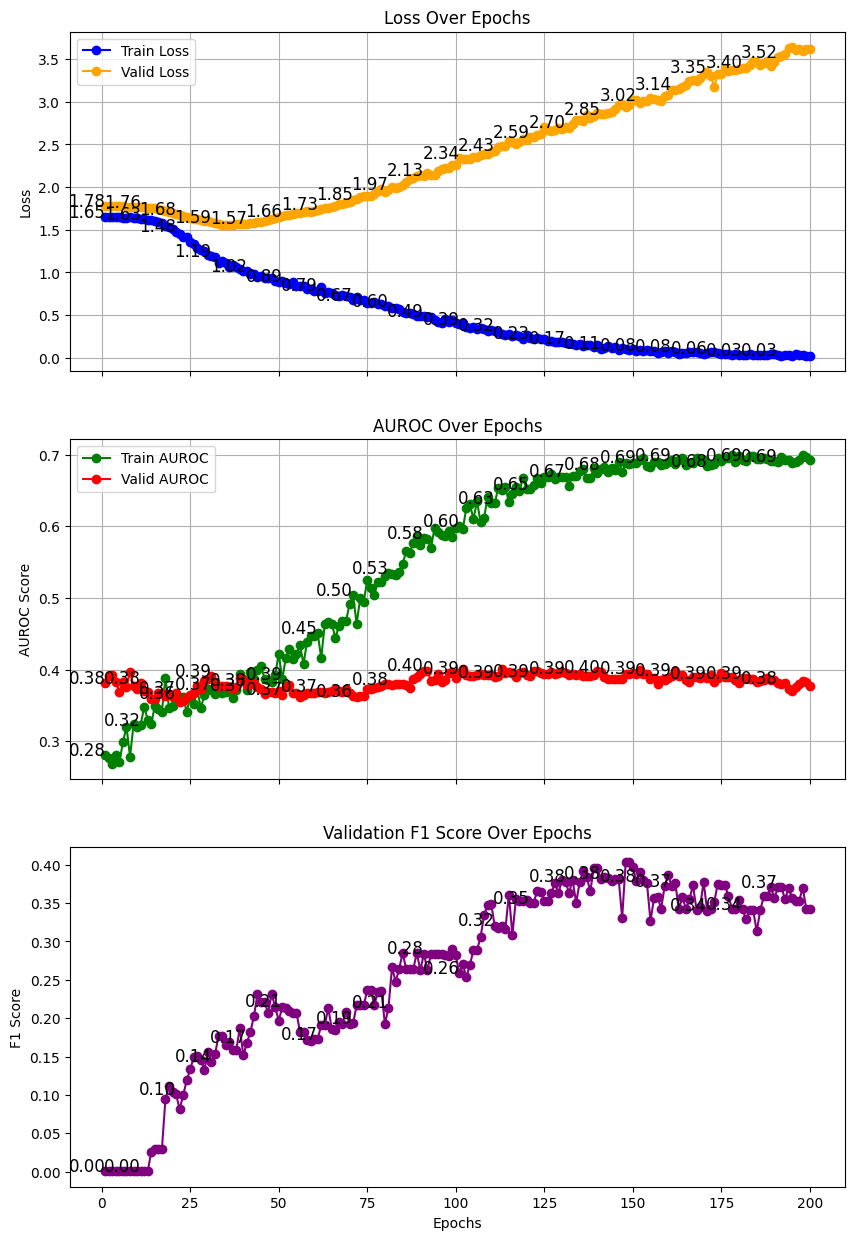

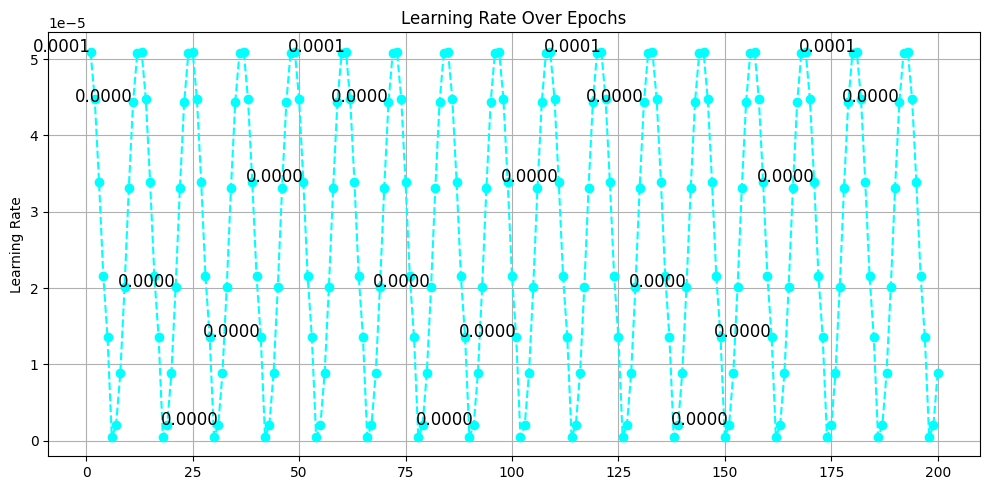

In [18]:
plot_metrics(history)

In [20]:
val_epoch_loss, val_epoch_auroc, val_epoch_f1 = valid_one_epoch(model=model, dataloader=validloader, criterion=criterion, 
                                         epoch=1)

  0%|          | 0/2 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s, Epoch=1, Valid_Auroc=0.422, Valid_F1=0.428, Valid_Loss=1.86]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00, 73.29it/s, Epoch=1, Valid_Auroc=0.394, Valid_F1=0.403, Valid_Loss=2.96]
